# 00 - Getting Started with `evosax` - The Ask-Eval-Tell API [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/00_getting_started.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX on NVIDIA GPU with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install `evosax` from PyPi:

In [2]:
%pip install -U "evosax[examples]"

## Import

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
seed = 0
key = jax.random.key(seed)

## Problem - Classic Black Box Optimization Benchmark

In [6]:
from evosax.problems import BBOBProblem as Problem

num_dims = 2
fn_name = "rosenbrock"

problem = Problem(
    fn_name=fn_name,
    num_dims=num_dims,
    x_opt=2.5 * jnp.ones(num_dims),
    f_opt=0.0,
    sample_rotations=False,
    seed=seed,
)

## Evolution Strategy - CMA-ES

In [7]:
from evosax.algorithms import CMA_ES as ES

num_generations = 64
population_size = 16

# Instantiate evolution strategy
key, subkey = jax.random.split(key)
solution = problem.sample(subkey)
es = ES(
    population_size=population_size,
    solution=solution,  # requires a dummy solution
)

# Use default parameters
params = es.default_params

# Initialize evolution strategy
key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

In [18]:
params  # You can have a look at the parameters and change those if desired

Params(std_init=1.0, std_min=0.0, std_max=100000000.0, weights=Array([ 0.3284362 ,  0.22205882,  0.15983205,  0.11568144,  0.08143557,
        0.05345466,  0.02979713,  0.00930406, -0.01924819, -0.05472849,
       -0.08682434, -0.11612552, -0.14308   , -0.168036  , -0.19126943,
       -0.21300286], dtype=float32), mu_eff=Array(4.8409142, dtype=float32), c_mean=1.0, c_std=Array(0.5777353, dtype=float32), d_std=Array(1.8407463, dtype=float32), c_c=Array(0.5922432, dtype=float32), c_1=Array(0.1271382, dtype=float32), c_mu=Array(0.2924523, dtype=float32), chi_n=Array(1.2542727, dtype=float32, weak_type=True))

## Run one generation

With our initialized evolutionary strategy, we can now proceed with the optimization process.

1. We `ask` the strategy to generate a set of candidate solutions.

2. We `eval` these candidates on our objective function.

3. We `tell` the strategy about the evaluation results, allowing it to update its internal state based on this feedback.

This ask-evaluate-tell cycle forms the core iteration loop of our evolutionary optimization process.

In [19]:
key, subkey = jax.random.split(key)
key_ask, key_eval, key_tell = jax.random.split(subkey, 3)

# Generate a set of candidate solutions to evaluate
population, state = es.ask(key_ask, state, params)

# Evaluate the fitness of the population
fitness, info = problem.eval(key_eval, population)

# Update the evolution strategy
state, metrics = es.tell(key_tell, population, fitness, state, params)

## Run

In [23]:
key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

metrics_log = []
for i in range(num_generations):
    key, subkey = jax.random.split(key)
    key_ask, key_eval, key_tell = jax.random.split(subkey, 3)

    population, state = es.ask(key_ask, state, params)

    fitness, info = problem.eval(key_eval, population)

    state, metrics = es.tell(key_tell, population, fitness, state, params)

    # Log metrics
    metrics_log.append(metrics)

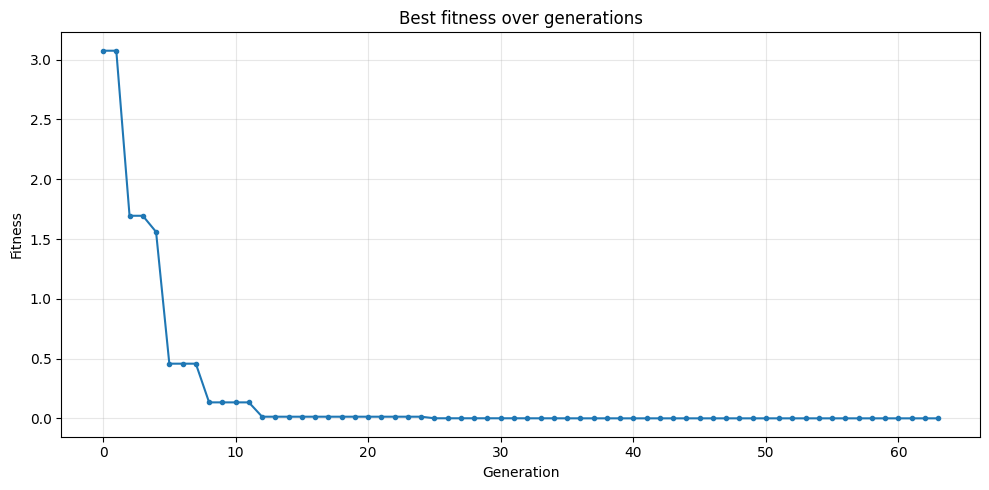

In [35]:
# Extract the best fitness values across generations
generations = [metrics["generation_counter"] for metrics in metrics_log]
best_fitness = [metrics["best_fitness"] for metrics in metrics_log]

plt.figure(figsize=(10, 5))
plt.plot(generations, best_fitness, label="Best Fitness", marker="o", markersize=3)

plt.title("Best fitness over generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Fitness Shaping

Evolutionary Algorithms implemented in `evosax` will always minimize the objective. If you want to maximize instead, you should simply add a minus sign to the fitness when you provide it to `tell`.

```python
fitness, info = problem.eval(key_eval, population)  # Fitness to maximize
state, metrics = es.tell(key_tell, population, -fitness, state, params)  # add minus sign to maximize
```

Evolution strategies in `evosax` have a default `fitness_shaping_fn`, that can be override. For example, the default `fitness_shaping_fn` for `Open_ES` is the centered rank fitness between but it can be replaced by any fitness shaping function in `evosax.core.fitness_shaping`.

In [37]:
from evosax.algorithms import Open_ES as ES
from evosax.core.fitness_shaping import add_weight_decay, standardize_fitness_shaping_fn

# Add weight decay and change the default fitness shaping function to standardize (z-score)
fitness_shaping_fn = add_weight_decay(standardize_fitness_shaping_fn, weight_decay=0.01)

num_generations = 64
population_size = 16

# Instantiate evolution strategy
key, subkey = jax.random.split(key)
solution = problem.sample(subkey)
es = ES(
    population_size=population_size,
    solution=solution,  # requires a dummy solution
    fitness_shaping_fn=fitness_shaping_fn,
)

# Use default parameters
params = es.default_params

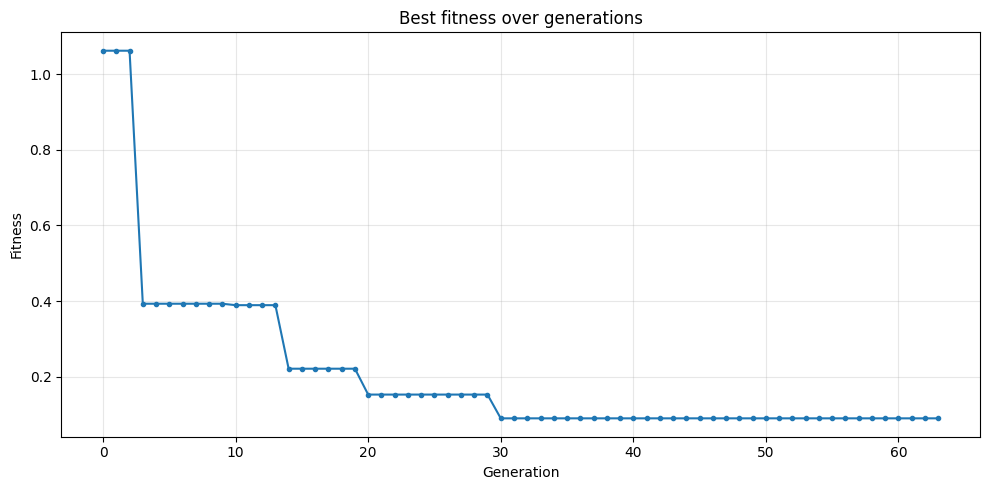

In [39]:
# Extract the best fitness values across generations
generations = [metrics["generation_counter"] for metrics in metrics_log]
best_fitness = [metrics["best_fitness"] for metrics in metrics_log]

plt.figure(figsize=(10, 5))
plt.plot(generations, best_fitness, label="Best Fitness", marker="o", markersize=3)

plt.title("Best fitness over generations")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Metrics

`evosax` provides various built-in metrics functions, but you can also define your own custom metrics function to include additional information or exclude metrics you don't need. For example, in the following example, we define a custom metrics function to log the diagonal matrix `D` used within Sep-CMA-ES.

In [8]:
from evosax.algorithms import Sep_CMA_ES as ES
from evosax.algorithms.distribution_based.base import metrics_fn


def custom_metrics_fn(
    key,
    population,
    fitness,
    state,
    params,
):
    metrics = metrics_fn(key, population, fitness, state, params)
    return metrics | {
        "D": state.D,
    }


es = ES(
    population_size=population_size,
    solution=solution,  # requires a dummy solution
    metrics_fn=custom_metrics_fn,
)

# Use default parameters
params = es.default_params

In [9]:
key, subkey = jax.random.split(key)
state = es.init(subkey, solution, params)

key, subkey = jax.random.split(key)
key_ask, key_eval, key_tell = jax.random.split(subkey, 3)

population, state = es.ask(key_ask, state, params)

fitness, info = problem.eval(key_eval, population)

state, metrics = es.tell(key_tell, population, fitness, state, params)

In [10]:
print(metrics.keys())

dict_keys(['D', 'best_fitness', 'best_fitness_in_generation', 'best_solution', 'best_solution_in_generation', 'best_solution_norm', 'generation_counter', 'mean', 'mean_norm'])


In [11]:
metrics["D"]

Array([1., 1.], dtype=float32)